In [1]:
!pip install keras-tuner --upgrade

In [38]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import zipfile
import matplotlib.image as mpimg
import keras_tuner as kt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import itertools



In [3]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total  --format=csv

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut5Corr.csv',sep = ';', header=0)
dados_crus = dados_crus.iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21,-1,-2]]

## Normal Dataset

In [5]:
V1 = np.array(dados_crus.pop('Semenov'))
V2 = np.array(dados_crus.pop('T_Limite'))

Labels = []
for i in range(len(V1)):
  if V1[i] > 0 or V2[i]> 0:
    Labels.append(1)
  else:
    Labels.append(0)
Labels = np.array(Labels)

dados_crus['Labels'] = Labels
df_runaway = dados_crus.query('Labels > 0')


In [6]:
test_dataset_runaway = df_runaway.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp = dados_crus.drop(df_runaway.index) #ou .query

test_dataset_NormalOp = NormalOp.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) #outra metade com instâncias comuns de operação

Test_dataset = pd.concat([test_dataset_runaway,test_dataset_NormalOp])

Train_dataset = dados_crus.drop(Test_dataset.index)


Test_dataset_Labels = Test_dataset.pop('Labels')

Train_dataset_Labels = Train_dataset.pop('Labels')


In [7]:
dados_crus

,Tempo,Conc,T_Reator,T_Jaqueta,Ff,Te,Tej,Ca0,Hrec,Ffj,Qm,Qr,Labels
0,0.000000,2.000000,311.150000,255.000000,56.0,289.15,256.15,2,-89700,2.032484,18.037788,135.694981,0
1,0.606061,1.978296,310.158835,256.878295,56.0,289.15,256.15,2,-89700,2.032484,16.253297,129.292939,0
2,1.212121,1.957900,309.208465,258.652581,56.0,289.15,256.15,2,-89700,2.032484,14.701465,123.177082,0
3,1.818182,1.938686,308.298080,260.328167,56.0,289.15,256.15,2,-89700,2.032484,13.347991,117.338962,0
4,2.424242,1.920547,307.426707,261.910131,56.0,289.15,256.15,2,-89700,2.032484,12.164007,111.769557,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4665595,57.575758,0.000003,826.348368,640.584410,56.0,289.15,256.15,2,-89700,2.032484,1968.714435,2306.585250,1
4665596,58.181818,0.000003,826.373689,640.836846,56.0,289.15,256.15,2,-89700,2.032484,1968.714442,2306.493621,1
4665597,58.787879,0.000003,826.397789,641.077153,56.0,289.15,256.15,2,-89700,2.032484,1968.714452,2306.406366,1
4665598,59.393939,0.000003,826.420725,641.305916,56.0,289.15,256.15,2,-89700,2.032484,1968.714456,2306.323278,1


# Dataset_PCA

In [8]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut5Corr.csv',sep = ';', header=0)
dados_crus = dados_crus.iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21,-1,-2]]

dados_crus.drop(['Semenov','T_Limite'],axis=1)

X_reduced = pd.DataFrame(dados_crus)
pca = PCA(n_components=5)
X_reduced = pd.DataFrame(pca.fit_transform(X_reduced))

X_reduced['Labels'] = Labels

df_runaway_PCA = X_reduced.query('Labels > 0')


test_dataset_runaway_PCA = df_runaway_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp_PCA = X_reduced.drop(df_runaway_PCA.index) #ou .query

test_dataset_NormalOp_PCA = NormalOp_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #outra metade com instâncias comuns de operação

Test_dataset_PCA = pd.concat([test_dataset_runaway_PCA,test_dataset_NormalOp_PCA])

Train_dataset_PCA = X_reduced.drop(Test_dataset_PCA.index)

Test_dataset_PCA_Labels = Test_dataset_PCA.pop('Labels')

Train_dataset_PCA_Labels = Train_dataset_PCA.pop('Labels')


In [9]:
dados_crus

,Tempo,Conc,T_Reator,T_Jaqueta,Ff,Te,Tej,Ca0,Hrec,Ffj,Qm,Qr,T_Limite,Semenov
0,0.000000,2.000000,311.150000,255.000000,56.0,289.15,256.15,2,-89700,2.032484,18.037788,135.694981,0,0
1,0.606061,1.978296,310.158835,256.878295,56.0,289.15,256.15,2,-89700,2.032484,16.253297,129.292939,0,0
2,1.212121,1.957900,309.208465,258.652581,56.0,289.15,256.15,2,-89700,2.032484,14.701465,123.177082,0,0
3,1.818182,1.938686,308.298080,260.328167,56.0,289.15,256.15,2,-89700,2.032484,13.347991,117.338962,0,0
4,2.424242,1.920547,307.426707,261.910131,56.0,289.15,256.15,2,-89700,2.032484,12.164007,111.769557,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4665595,57.575758,0.000003,826.348368,640.584410,56.0,289.15,256.15,2,-89700,2.032484,1968.714435,2306.585250,1,0
4665596,58.181818,0.000003,826.373689,640.836846,56.0,289.15,256.15,2,-89700,2.032484,1968.714442,2306.493621,1,0
4665597,58.787879,0.000003,826.397789,641.077153,56.0,289.15,256.15,2,-89700,2.032484,1968.714452,2306.406366,1,0
4665598,59.393939,0.000003,826.420725,641.305916,56.0,289.15,256.15,2,-89700,2.032484,1968.714456,2306.323278,1,0


# Cont

In [ ]:
test_dataset_runaway.shape

(46656, 23)

In [ ]:
test_dataset_NormalOp.shape

(46656, 23)

In [ ]:
Test_dataset.shape

(93312, 21)

In [ ]:
Test_dataset_PCA.shape

(93312, 4)

In [ ]:
Test_Labels.shape

(93312,)

In [ ]:
Train_dataset.shape

(4572288, 21)

In [ ]:
Train_dataset_PCA.shape

(4572288, 4)

In [ ]:
Labels_Train.shape

(4572288,)

In [ ]:
dados_crus.shape

(4665600, 21)

In [ ]:
Test_dataset.shape[0]+Train_dataset.shape[0]

4665600

In [ ]:
len(Labels)

4665600

In [ ]:
model=tf.keras.Sequential([tf.keras.layers.Dense(64,input_shape=[21],activation = 'relu'),
                           tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.Dense(64,activation='relu',bias_regularizer=regularizers.l2(1e-3)),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.Dense(32,activation='relu'),
                  tf.keras.layers.Dense(16,activation='relu'),

                  tf.keras.layers.Dense(1,activation = 'sigmoid')])

In [ ]:
model=keras.Sequential()
model.add(keras.layers.Dense(128,input_shape=[4],activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dense(64,activation='relu',bias_regularizer=regularizers.l2(1e-4)))
for i in range(20):
    model.add(keras.layers.Dense(64,
                                 #bias_regularizer=regularizers.l1(1e-3),
                                 activation='LeakyReLU'))
    model.add(keras.layers.BatchNormalization())
                 
model.add(keras.layers.Dense(1,activation = 'sigmoid'))

In [10]:
model=keras.Sequential()

model.add(keras.layers.Dense(64,input_shape=[12],
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(32,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(16,activation = 'LeakyReLU'))



model.add(keras.layers.Dense(1, activation='sigmoid'))

  


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                5

In [12]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6),loss='binary_crossentropy',metrics=['mae','mse','accuracy'])

In [13]:
history = model.fit(x=Train_dataset,y=Train_dataset_Labels,validation_data = (Test_dataset,Test_dataset_Labels)
                    ,validation_steps = len(Test_dataset)/400 ,epochs = 20 ,batch_size=400,verbose=1
                    )

Epoch 1/20
11548/11548 [==============================] - 55s 5ms/step - loss: 0.6770 - mae: 0.4583 - mse: 0.2399 - accuracy: 0.5905 - val_loss: 0.4591 - val_mae: 0.3440 - val_mse: 0.1452 - val_accuracy: 0.8364
Epoch 2/20
11548/11548 [==============================] - 52s 4ms/step - loss: 0.3119 - mae: 0.2366 - mse: 0.0878 - accuracy: 0.9074 - val_loss: 0.4252 - val_mae: 0.2602 - val_mse: 0.1341 - val_accuracy: 0.8299
Epoch 3/20
11548/11548 [==============================] - 52s 4ms/step - loss: 0.2386 - mae: 0.1680 - mse: 0.0655 - accuracy: 0.9240 - val_loss: 0.4772 - val_mae: 0.2414 - val_mse: 0.1476 - val_accuracy: 0.8169
Epoch 4/20
11548/11548 [==============================] - 52s 5ms/step - loss: 0.2104 - mae: 0.1402 - mse: 0.0595 - accuracy: 0.9268 - val_loss: 0.8157 - val_mae: 0.2972 - val_mse: 0.2325 - val_accuracy: 0.7119
Epoch 5/20
 4365/11548 [==========>...................] - ETA: 31s - loss: 0.1985 - mae: 0.1304 - mse: 0.0570 - accuracy: 0.9276

KeyboardInterrupt: ignored

In [ ]:

for i in ['loss', 'mae', 'mse', 'accuracy']:
  plt.plot(history.history[i])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
?history

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'mae', 'mse', 'accuracy'])


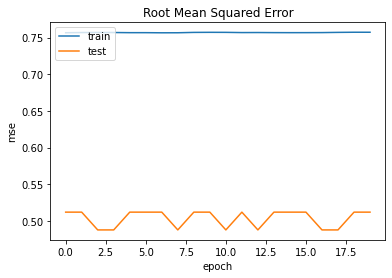

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_mse'])
plt.title('Root Mean Squared Error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(Train_dataset_PCA,Train_Labels, test_size=0.5, train_size=0.5,shuffle=True)
Train_Dataset_Split = pd.concat([df_runaway_PCA,X_train]).iloc[:,:-1]
Train_Dataset_Split
Labels_Train_Split = 

,0,1,2,3,4
239700,-328.651352,316.751794,-38.474425,-0.436873,-0.198625
239701,-324.440361,314.823265,-36.798016,-0.123177,-0.174490
239702,-320.016802,312.863016,-35.177213,0.165983,-0.152219
239703,-315.365644,310.864565,-33.610976,0.432367,-0.131672
239704,-310.468521,308.821314,-32.098305,0.677599,-0.112715
...,...,...,...,...,...
500168,892.017489,-1037.538214,72.409835,0.683655,-0.152483
3249014,-327.447923,321.664151,-14.133913,-0.694313,0.016671
2843510,-204.536931,246.900865,-27.220937,1.011910,-0.754445
4154243,12.978759,-12.151465,-6.582460,-1.590495,0.131226


In [15]:
def build_model(hp):
  model = keras.Sequential()

  model.add(keras.layers.Dense(
        hp.Choice('unitsPre1', [32, 64,128]),
        bias_regularizer=regularizers.l1(1e-4),
        activation='LeakyReLU'))
  
  model.add(keras.layers.Dense(
      hp.Choice('unitsPre2', [32, 64,128]),
      bias_regularizer=regularizers.l1(1e-4),
      activation='LeakyReLU'))
  
  for i in range(hp.Int('num_layers',4,8)):
    if i % 2 == 0:
      model.add(keras.layers.Dense(
        hp.Choice('units' + str(i), [16, 32, 64]),
        bias_regularizer=regularizers.l1(1e-3),
        activation='LeakyReLU'))
      model.add(keras.layers.BatchNormalization())
    else:
      model.add(keras.layers.Dense(
          hp.Choice('units' + str(i), [16, 32]),
          activation='LeakyReLU'))
      
  
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-5,1e-6])),loss='binary_crossentropy',metrics=['mae','mse','accuracy'])
  #model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001
   #                                                   ,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad"),loss='binary_crossentropy',metrics=['mae','mse','accuracy'])
  
  return model

In [17]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=10,
                     factor=6,
                     directory='/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/',
                     project_name='Reactor_NN_Tuner_Hyperband+',
                     overwrite=False)
#tuner.search(Train_dataset_PCA, Train_dataset_PCA_Labels,
#             validation_data=(Test_dataset_PCA, Test_dataset_PCA_Labels),
#             validation_steps = len(Test_dataset)/400 ,batch_size=400)
#tuner.get_best_models()

Trial 14 Complete [00h 10m 00s]
val_accuracy: 0.9164523482322693

Best val_accuracy So Far: 0.9258401989936829
Total elapsed time: 01h 08m 48s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#tuner = kt.Hyperband(
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    executions_per_trial=1,
    max_trials=40,
    directory ='/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/',
    project_name='Reactor_NN_Tuner2',
    overwrite = True)

#tuner.search(Train_dataset_PCA, Train_Labels, 
#             epochs=5, validation_data=(Test_dataset_PCA, Test_Labels),
#             validation_steps = len(Test_dataset)/400 ,batch_size=400)
tuner.get_best_models()


[]

In [ ]:
Test_dataset

In [ ]:
Test_Labels.shape

(93312,)

In [ ]:
Train_dataset

In [ ]:
len(Train_Labels)

In [ ]:
Test_dataset

In [ ]:
dados_crus.drop(Test_dataset.index).iloc[:,[21,22]].shape


In [ ]:
Test_Labels.shape

(4665600,)

In [ ]:
v1.shape

(93312,)

In [ ]:
?model.fit

Object `model.fit` not found.


In [ ]:
range(len(Train_dataset))

range(0, 4572288)

In [ ]:
Test_dataset

In [ ]:
?Best_Model

Object `Best_Model` not found.


In [18]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband+
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
unitsPre1: 64
unitsPre2: 64
num_layers: 6
units0: 16
units1: 16
units2: 64
units3: 16
learning_rate: 1e-05
units4: 32
units5: 16
units6: 32
units7: 16
tuner/epochs: 10
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 11a34bb333e7db44a82f521994fd3bd7
Score: 0.9258401989936829
Trial summary
Hyperparameters:
unitsPre1: 32
unitsPre2: 64
num_layers: 4
units0: 16
units1: 16
units2: 32
units3: 32
learning_rate: 1e-05
units4: 64
units5: 32
units6: 16
units7: 32
tuner/epochs: 10
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 5165f320c48323887dcc6c5967a73185
Score: 0.9228180646896362
Trial summary
Hyperparameters:
unitsPre1: 128
unitsPre2: 64
num_layers: 4
units0: 32
units1: 32
units2: 32
units3: 32
learning_rate: 1e-05
units4: 64
units5: 32
unit

In [ ]:
tuner.load_model(trial.best_step)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband')

In [ ]:
tuner.get_best_models()

In [ ]:
tuner.

In [ ]:
Oracle

In [ ]:
model2 = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])

In [ ]:
model2.fit(x=Train_dataset_PCA,y=Labels_Train,validation_data = (Test_dataset_PCA,Test_Labels),
           validation_steps = len(Test_dataset)/400 ,epochs = 20 ,batch_size=400,verbose=1
           )

In [ ]:
model2.summary() 

In [ ]:
tuner.get_best_hyperparameters()

In [34]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.build((Train_dataset_PCA.shape[0],5))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (4618944, 64)             384       
_________________________________________________________________
dense_1 (Dense)              (4618944, 64)             4160      
_________________________________________________________________
dense_2 (Dense)              (4618944, 16)             1040      
_________________________________________________________________
batch_normalization (BatchNo (4618944, 16)             64        
_________________________________________________________________
dense_3 (Dense)              (4618944, 16)             272       
_________________________________________________________________
dense_4 (Dense)              (4618944, 64)             1088      
_________________________________________________________________
batch_normalization_1 (Batch (4618944, 64)             2

In [20]:
model2 = tuner.get_best_models(num_models=1)[0]
model2.build((Train_dataset_PCA.shape[0],10))

In [28]:
model2.load_weights('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/Reactor_NN_Tuner_Hyperband3/trial_1e4f0bc0faa8447062caa902c4afe468/checkpoints/epoch_0/checkpoint')


In [30]:
predicts = model2.predict(Test_dataset_PCA)

In [32]:
rounded_pred = np.argmax(predicts,axis=-1)

In [35]:
rounded_pred.sum()

0

In [21]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut5Corr.csv',sep = ';', header=0)
dados_crus = dados_crus.iloc[:,1:]
X_reduced = pd.DataFrame(dados_crus)
pca = PCA(n_components=10)
X_reduced = pd.DataFrame(pca.fit_transform(X_reduced))

In [20]:
X_reduced

,Tempo,Conc,T_Reator,T_Jaqueta,Ff,V,Te,Tej,k0,Ca0,RhoCp,Hrec,U,A,Ea,R,Vj,RhoCpj,Ffj,Qm,Qr,Semenov,T_Limite
0,0.000000,2.000000,311.150000,255.000000,56.0,14,289.15,256.15,1.696000e+12,2,3570,-89700,1100,40,75500,8.314462,3.5,3700,2.032484,18.037788,135.694981,0,0
1,0.606061,1.978296,310.158835,256.878295,56.0,14,289.15,256.15,1.696000e+12,2,3570,-89700,1100,40,75500,8.314462,3.5,3700,2.032484,16.253297,129.292939,0,0
2,1.212121,1.957900,309.208465,258.652581,56.0,14,289.15,256.15,1.696000e+12,2,3570,-89700,1100,40,75500,8.314462,3.5,3700,2.032484,14.701465,123.177082,0,0
3,1.818182,1.938686,308.298080,260.328167,56.0,14,289.15,256.15,1.696000e+12,2,3570,-89700,1100,40,75500,8.314462,3.5,3700,2.032484,13.347991,117.338962,0,0
4,2.424242,1.920547,307.426707,261.910131,56.0,14,289.15,256.15,1.696000e+12,2,3570,-89700,1100,40,75500,8.314462,3.5,3700,2.032484,12.164007,111.769557,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4665595,57.575758,0.000003,826.348368,640.584410,56.0,14,289.15,256.15,1.696000e+12,2,3570,-89700,1100,40,75500,8.314462,3.5,3700,2.032484,1968.714435,2306.585250,0,1
4665596,58.181818,0.000003,826.373689,640.836846,56.0,14,289.15,256.15,1.696000e+12,2,3570,-89700,1100,40,75500,8.314462,3.5,3700,2.032484,1968.714442,2306.493621,0,1
4665597,58.787879,0.000003,826.397789,641.077153,56.0,14,289.15,256.15,1.696000e+12,2,3570,-89700,1100,40,75500,8.314462,3.5,3700,2.032484,1968.714452,2306.406366,0,1
4665598,59.393939,0.000003,826.420725,641.305916,56.0,14,289.15,256.15,1.696000e+12,2,3570,-89700,1100,40,75500,8.314462,3.5,3700,2.032484,1968.714456,2306.323278,0,1


TypeError: ignored

In [62]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[19393  3935]
 [ 6488 16840]]


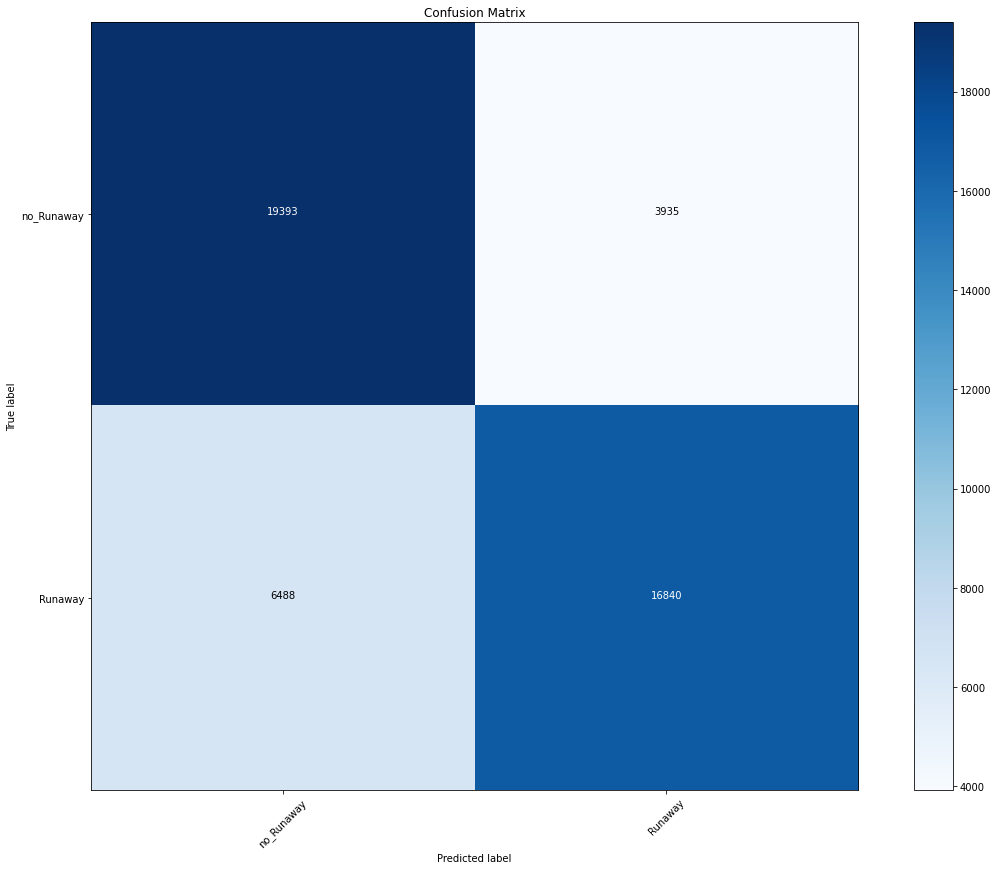

In [63]:
predictions = model.predict(
      x=Test_dataset_PCA
    , batch_size=400
    , verbose=0
)  


cm = confusion_matrix(y_true=Test_dataset_PCA_Labels, y_pred=predictions.round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


In [33]:
Test_dataset_PCA.shape

(46656, 5)

In [40]:
predictions = model.predict(
      x=Test_dataset_PCA
    , batch_size=400
    , verbose=0
) 

In [56]:
predictions.round()

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [54]:
np.argmax(predictions)

21192